# 🧠 Qwen2.5 Brain MRI Description Generation

Generate medical descriptions for each MRI slice using Qwen2.5 and evaluate with BLEU.

## 1. Setup & Imports

In [48]:
import os, json, base64
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def encode_image_to_data_uri(path: str) -> str:
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode('utf-8')
    return f"data:image/png;base64,{b64}"

DATASET_DIR = "VLM-Seminar25-Dataset/nova_brain"
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
ANNOT_PATH = os.path.join(DATASET_DIR, "annotations.json")
RESULTS_DIR = "../results/nova_brain/descriptions"
os.makedirs(RESULTS_DIR, exist_ok=True)

with open(ANNOT_PATH, "r") as f:
    annotations = json.load(f)
case_ids = list(annotations.keys())

load_dotenv(dotenv_path="../config/user.env")
api_key = os.environ.get("NEBIUS_API_KEY")
client = OpenAI(base_url="https://api.studio.nebius.com/v1/", api_key=api_key)

In [49]:
do_new_inference = False 

## 2. Model Inference

In [50]:
description_results = []
if do_new_inference:
    one_shot = False  # NOTE Set to False if you want to use zero-shot prompting

    for case_id in tqdm(case_ids):
        case = annotations[case_id]
        for img_name, img_info in case.get("image_findings", {}).items():
            img_path = os.path.join(IMAGES_DIR, img_name)
            data_uri = encode_image_to_data_uri(img_path)
            prompt = "Please describe the given medical image as if you are a Doctor trying to analyze. Goal is a very concise and accurate description of the image content, focusing on abnormalities or significant findings. The description should be in English and suitable for a medical report."
            prompt_one_shot = "Please describe the given medical image as if you are a Doctor trying to analyze. Goal is a very concise and accurate description of the image content, focusing on abnormalities or significant findings. The description should be in English and suitable for a medical report. E.g. 'Axial T2 - weighted image showed high signal of the pons.'"
            if one_shot:
                prompt = prompt_one_shot
            
            completion = client.chat.completions.create(
                model="Qwen/Qwen2.5-VL-72B-Instruct",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {"type": "image_url", "image_url": {"url": data_uri}},
                        ],
                    }
                ],
            )
            pred = completion.choices[0].message.content.strip()
            description_results.append({
                "case_id": case_id,
                "image": img_name,
                "prediction": pred,
                "ground_truth": img_info.get("caption", ""),
                "one_shot": one_shot,
            })

## 3. Save Model Predictions

In [53]:
if not do_new_inference:
    # set one_shot based on the existing results 
    one_shot = False
    print(one_shot)
else:
    print(one_shot)

False


In [56]:
name = "qwen2_5_description_results_one_shot.json" if one_shot else "qwen2_5_description_results_zero_shot.json"
if description_results:  # Only save if not empty
    with open(os.path.join(RESULTS_DIR, name), "w") as f:
        json.dump(description_results, f, indent=2)
    print("Saved description results ", name)
else:
    print("description_results is empty, not saving.")
name

description_results is empty, not saving.


'qwen2_5_description_results_zero_shot.json'

Load results

In [57]:
with open(os.path.join(RESULTS_DIR, name), "r") as f:
    description_results = json.load(f)
print(f"Number of descriptions: {len(description_results)} for {name}")

Number of descriptions: 92 for qwen2_5_description_results_zero_shot.json


## 4. Evaluation & Metrics

### Using BLEU

In [21]:
# Evaluation: Compute BLEU for each image and save as JSON
import sys
sys.path.append("eval_scripts")
from evaluate_bleu import evaluate_bleu
import pandas as pd

# Ensure NLTK punkt is downloaded for tokenization
import nltk
#nltk.download('punkt')
#nltk.download('punkt_tab')

gt = [x["ground_truth"] for x in description_results]
pred = [x["prediction"] for x in description_results]

# Pass meta info to include case_id and image in BLEU results
bleu_results = evaluate_bleu(gt, pred, meta=description_results)

# Save as JSON
bleu_json_path = os.path.join(RESULTS_DIR, "bleu_per_image.json")
with open(bleu_json_path, "w") as f:
    json.dump(bleu_results, f, indent=2)
print(f"Saved per-image BLEU results to {bleu_json_path}")

# Optionally, convert to DataFrame for further analysis
bleu_df = pd.DataFrame(bleu_results)
bleu_df.head()

Saved per-image BLEU results to ../results/nova_brain/descriptions\bleu_per_image.json


,index,reference,candidate,bleu1,bleu2,bleu3,bleu4,case_id,image
0,0,Axial contrast-enhanced T1 3D sequence shows a...,"This axial MRI image demonstrates a large, wel...",0.052083,3.404251e-155,3.355505e-204,8.703281e-232,case0061,case0061_001.png
1,1,Axial T2 gradient image shows a small hypointe...,This axial T2-weighted MRI image of the brain ...,0.098039,3.115582e-02,3.022453e-103,2.632945e-155,case0061,case0061_002.png
2,2,T1 sequence showing high signal in basal gangl...,This axial T2-weighted MRI image of the brain ...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,case0246,case0246_001.png
3,3,Micronodule abscess into the right centrum sem...,This axial T2-weighted MRI image of the brain ...,0.136842,3.815452e-02,3.454968e-103,2.913702e-155,case0115,case0115_007.png
4,4,Micronodule abscess into the right centrum sem...,This axial T2-weighted MRI image of the brain ...,0.171429,4.984448e-02,4.121458e-103,3.330280e-155,case0115,case0115_001.png


In [20]:
name_second = "qwen2_5_description_results_one_shot.json" if not one_shot else "qwen2_5_description_results_zero_shot.json"
description_results_second = []
with open(os.path.join(RESULTS_DIR, name_second), "r") as f:
    description_results_second = json.load(f)
print(f"Number of descriptions: {len(description_results_second)} for {name_second}")

gt_second = [x["ground_truth"] for x in description_results_second]
pred_second = [x["prediction"] for x in description_results_second]

# Pass meta info to include case_id and image in BLEU results
bleu_results_second = evaluate_bleu(gt_second, pred_second, meta=description_results_second)

Number of descriptions: 92 for qwen2_5_description_results_one_shot.json


c:\Users\dgars\miniconda3\envs\ml4reg\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\dgars\miniconda3\envs\ml4reg\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\dgars\miniconda3\envs\ml4reg\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram or

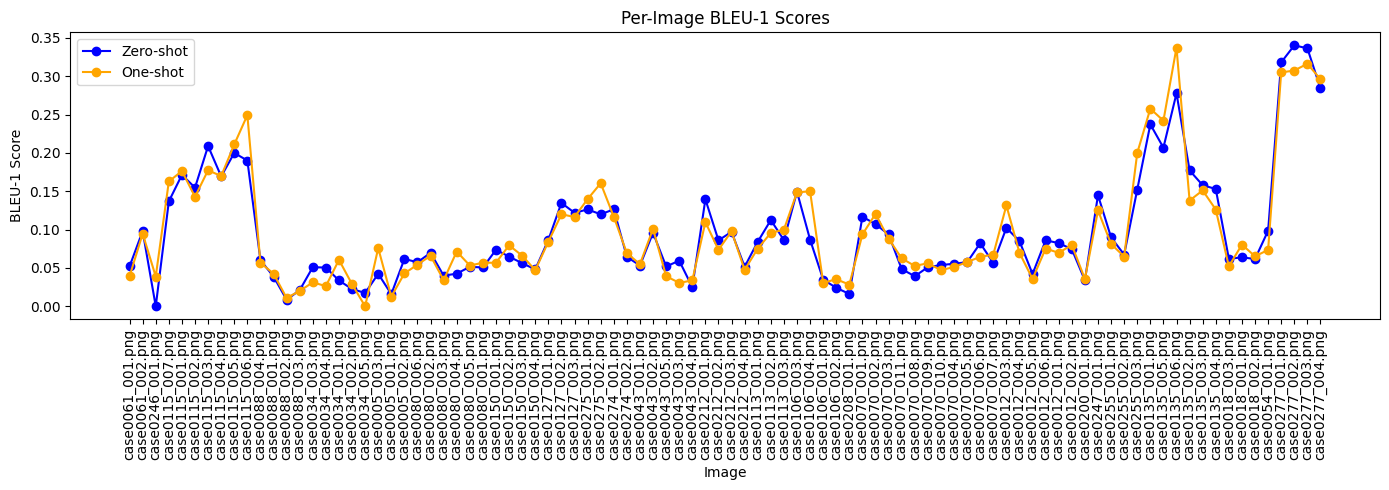

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

# Extract BLEU-1 scores and image names
bleu1_scores = [x.get("bleu1", 0) for x in bleu_results]
image_names = [x.get("image", f"img_{i}") for i, x in enumerate(bleu_results)]
plt.plot(image_names, bleu1_scores, marker='o', linestyle='-', color='b', label='Zero-shot' if "zero_shot" in name else 'One-shot')

# Extract BLEU-1 scores and image names
bleu1_scores = [x.get("bleu1", 0) for x in bleu_results_second]
image_names = [x.get("image", f"img_{i}") for i, x in enumerate(bleu_results_second)]
plt.plot(image_names, bleu1_scores, marker='o', linestyle='-', color='orange', label='One-shot' if "one_shot" in name_second else 'zero-shot')

plt.xticks(rotation=90)
plt.xlabel("Image")
plt.ylabel("BLEU-1 Score")
plt.title("Per-Image BLEU-1 Scores")
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(RESULTS_DIR, "bleu_per_image_comparison.png"))
plt.show()

### Using LLM to evaluate

In [58]:
name, name_second

('qwen2_5_description_results_zero_shot.json',
 'qwen2_5_description_results_one_shot.json')

In [60]:
llm_eval_results = []

# TODO change to description_results_second if you want to use the second set
for x in tqdm(description_results):
    gt = x["ground_truth"]
    pred = x["prediction"]
    prompt = (
        "You are a medical expert. Given the following ground truth caption and predicted caption for a brain MRI image, please rate how well the prediction matches the ground truth ."
        "Return ONLY the integer rating (1-5), NOTHING else. Rating scale:\n 1 - completely wrong\n  2 - mostly wrong\n 3 - moderately ok\ns 4 - mostly correct\n 5 - meaning is exactly the same\n\n"
        f"Ground Truth description: {gt}\n"
        f"Prediction description: {pred}\n"
        "Rating:"
    )
    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-VL-72B-Instruct",
        messages=[
            {"role": "user", "content": prompt}
        ],
    )
    score_str = completion.choices[0].message.content.strip()
    try:
        score = int(score_str)
    except Exception:
        print(f"Error parsing score: {score_str}")
        score = None

    llm_eval_results.append({
        "case_id": x["case_id"],
        "image": x["image"],
        "ground_truth": gt,
        "prediction": pred,
        "llm_score": score,
    })

# Save LLM evaluation results TODO change to name_second if you want to use the second set
llm_json_path = os.path.join(RESULTS_DIR, f"llm_eval_per_image_{name}_v2.json")
with open(llm_json_path, "w") as f:
    json.dump(llm_eval_results, f, indent=2)
print(f"Saved per-image LLM evaluation results to {llm_json_path}")

100%|██████████| 92/92 [00:27<00:00,  3.36it/s]


Saved per-image LLM evaluation results to ../results/nova_brain/descriptions\llm_eval_per_image_qwen2_5_description_results_zero_shot.json_v2.json


### PLot both results

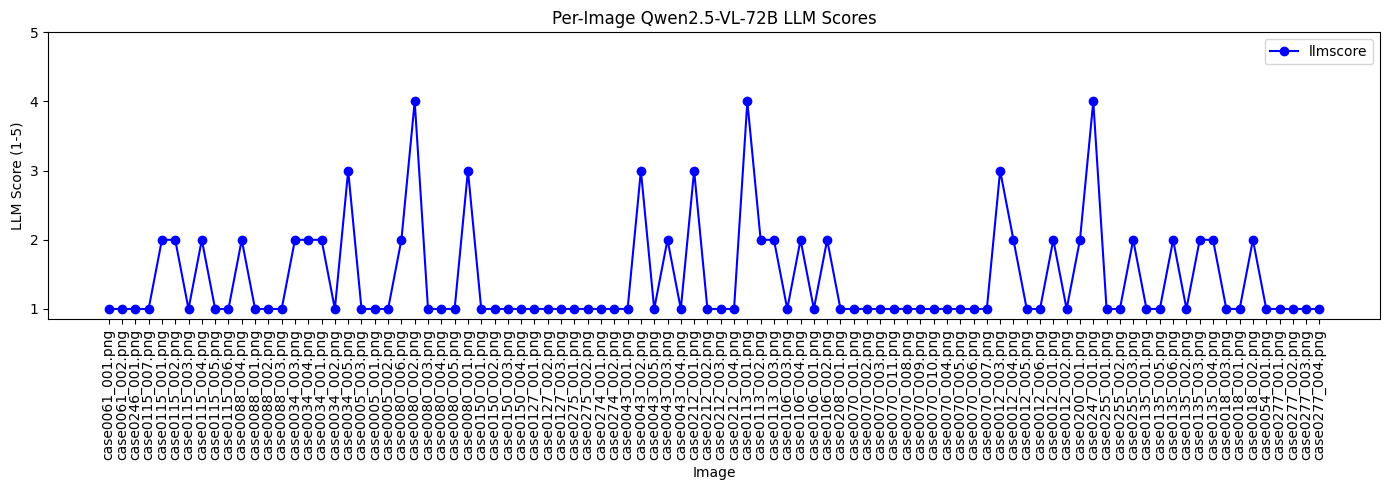

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

scores = [x.get("llm_score", 0) for x in llm_eval_results]
image_names = [x.get("image", f"img_{i}") for i, x in enumerate(llm_eval_results)]
plt.plot(image_names, scores, marker='o', linestyle='-', color='b', label='llmscore')

plt.xticks(rotation=90)
plt.xlabel("Image")
plt.yticks(range(1, 6))  # Assuming scores are from 1 to 5
plt.ylabel("LLM Score (1-5)")
plt.title("Per-Image Qwen2.5-VL-72B LLM Scores")
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(RESULTS_DIR, "llm_score_per_image_comparison.png"))
plt.show()

LLM vs BLEU

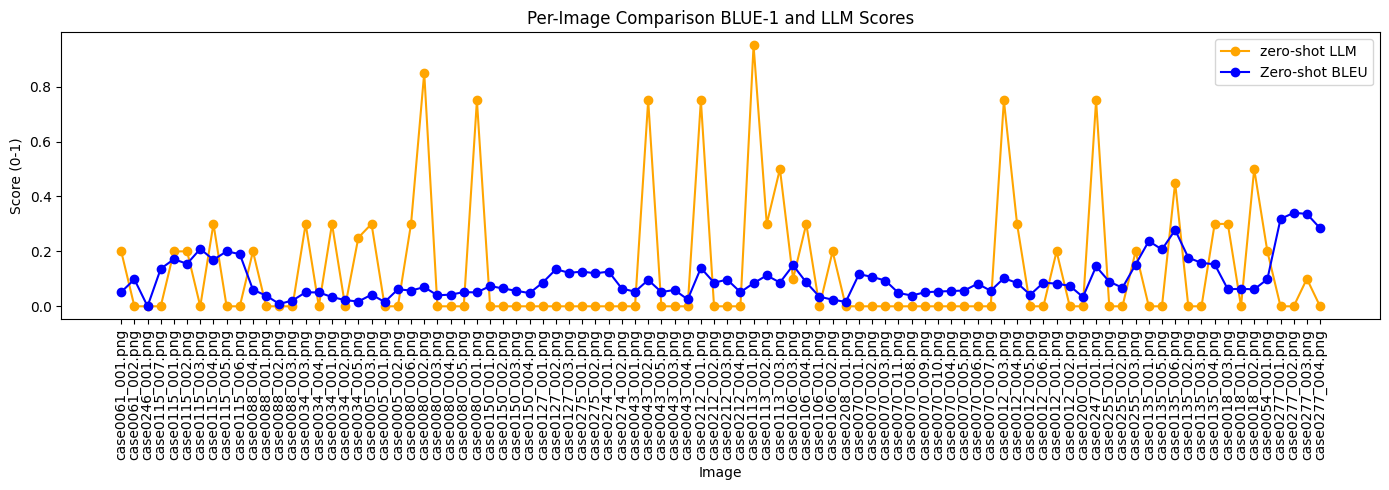

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

scores = [x.get("llm_score", 0) for x in llm_eval_results_zero]
image_names = [x.get("image", f"img_{i}") for i, x in enumerate(llm_eval_results_zero)]
plt.plot(image_names, scores, marker='o', linestyle='-', color='orange', label='zero-shot LLM')

# scores = [x.get("llm_score", 0) for x in llm_eval_results_one]
# image_names = [x.get("image", f"img_{i}") for i, x in enumerate(llm_eval_results_one)]
# plt.plot(image_names, scores, marker='o', linestyle='-', color='orange', label='one-shot LLM')

# Extract BLEU-1 scores and image namesw
bleu1_scores = [x.get("bleu1", 0) for x in bleu_results]
image_names = [x.get("image", f"img_{i}") for i, x in enumerate(bleu_results)]
plt.plot(image_names, bleu1_scores, marker='o', linestyle='-', color='b', label='Zero-shot BLEU' if "zero_shot" in name else 'One-shot')

# Extract BLEU-1 scores and image names
# bleu1_scores = [x.get("bleu1", 0) for x in bleu_results_second]
# image_names = [x.get("image", f"img_{i}") for i, x in enumerate(bleu_results_second)]
# plt.plot(image_names, bleu1_scores, marker='o', linestyle='-', color='b', label='One-shot BLEU' if "one_shot" in name_second else 'zero-shot')

plt.xticks(rotation=90)
plt.xlabel("Image")
plt.ylabel("Score (0-1)")
plt.title("Per-Image Comparison BLUE-1 and LLM Scores")
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(RESULTS_DIR, "bleu_vs_llm_per_image_comparison_zeroshot.png"))
plt.show()